## 0. Prerequisites

### 0.0. install LightAutoML

In [1]:
#!pip install -U lightautoml

### 0.1. Import libraries


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [33]:
# Standard python libraries
import os
import json
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch
import ast

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco
from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from scipy.spatial import distance
from sklearn.metrics import precision_recall_curve, auc, precision_score
from fuzzywuzzy import fuzz
from Levenshtein import distance as lev
from Levenshtein import ratio
from collections import defaultdict
tqdm.pandas()

### 0.2. Constants


In [55]:
N_THREADS = 16
N_FOLDS = 8
RANDOM_STATE = 737
TEST_SIZE = 0.1
TIMEOUT = 7000
TARGET_NAME = 'target'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [6]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [5]:
train_features = pd.read_parquet('train_data.parquet').astype({'variantid': int})
train_features.head()

,variantid,name,categories,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping
0,51195767,"Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[оранжевый],None,"[[0.04603629, 0.18839523, -0.09973055, -0.6636...","[-0.47045058, 0.67237014, 0.48984158, -0.54485...","{""Номинальный ток, А"":[""10""],""Цвет товара"":[""о..."
1,53565809,Магнитный кабель USB 2.0 A (m) - USB Type-C (m...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ...",[красный],"[[0.26863545, -0.3130674, 0.29023397, 0.073978...","[[1.1471839, -0.665361, 0.7745614, 0.26716197,...","[-0.6575592, 0.6522429, 0.5426037, -0.54347897...","{""Конструктивные особенности"":[""Магнитная конс..."
2,56763357,"Набор микропрепаратов Konus 25: ""Клетки и ткан...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Оптичес...",None,"[[0.66954195, 1.0643557, 0.78324044, -0.338267...","[[-0.90570974, 1.0296293, 1.0769907, 0.27746, ...","[-0.7384308, 0.70784587, 0.3012653, -0.3583719...","{""Тип аксессуара"":[""Набор микропрепаратов""],""Б..."
3,56961772,"Мобильный телефон BQ 1848 Step, черный","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смартфо...",[черный],"[[0.6580482, -0.35763323, -0.16939065, -0.4249...","[[0.13133773, -0.5577079, 0.32498044, 0.191717...","[-0.44812852, 0.5283565, 0.28981736, -0.506841...","{""Тип карты памяти"":[""microSD""],""Число SIM-кар..."
4,61054740,"Штатив трипод Tripod 330A для фотоаппаратов, в...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Штативы...",[черный],"[[-0.10406649, 0.080646515, -0.28668788, 0.739...","[[0.21696381, 0.10989461, -0.08012986, 0.69186...","[-0.72692573, 0.75206333, 0.37740713, -0.52502...","{""Материал"":[""Металл""],""Количество секций, шт""..."


In [6]:
train_pairs = pd.read_parquet('train_pairs_after_split_v2.parquet').astype({'variantid1': int, 'variantid2': int})
valid_pairs = pd.read_parquet('val_pairs_v2.parquet').astype({'variantid1': int, 'variantid2': int})

In [7]:
test_pairs = pd.read_parquet('test_pairs_wo_target.parquet').astype({'variantid1': int, 'variantid2': int})
test_features = pd.read_parquet('test_data.parquet').astype({'variantid': int})
test_pairs.head()

,variantid1,variantid2,cat3_grouped
0,52076340,290590137,Батарейки и аккумуляторы
1,64525522,204128919,"Смартфоны, планшеты, мобильные телефоны"
2,77243372,479860557,Кабели и переходники
3,86065820,540678372,Устройство ручного ввода
4,91566575,258840506,"Смартфоны, планшеты, мобильные телефоны"


In [8]:
smart_tokens = pd.read_parquet('data_names_smart_tok_bert_diff_characteristics_bm25_char.parquet') \
    .drop(columns=['name_toked_1','name_toked_2']) \
    .astype({'variantid1': int, 'variantid2': int})

smart_tokens['fuzz_clean_name'] = smart_tokens.apply(lambda row: fuzz.ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
smart_tokens['fuzz_partial_clean_name'] = smart_tokens.apply(lambda row: fuzz.partial_ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
smart_tokens['fuzz_token_clean_name'] = smart_tokens.apply(lambda row: fuzz.token_sort_ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
smart_tokens['fuzz_WRatio_clean_name'] = smart_tokens.apply(lambda row: fuzz.WRatio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
smart_tokens['lev_clean_name'] = smart_tokens.apply(lambda row: lev(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
smart_tokens['lev_ratio_clean_name'] = smart_tokens.apply(lambda row: ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)

smart_tokens['fuzz_service_name'] = smart_tokens.apply(lambda row: fuzz.ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
smart_tokens['fuzz_partial_service_name'] = smart_tokens.apply(lambda row: fuzz.partial_ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
smart_tokens['fuzz_token_service_name'] = smart_tokens.apply(lambda row: fuzz.token_sort_ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
smart_tokens['fuzz_WRatio_service_name'] = smart_tokens.apply(lambda row: fuzz.WRatio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
smart_tokens['lev_service_name'] = smart_tokens.apply(lambda row: lev(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
smart_tokens['lev_ratio_service_name'] = smart_tokens.apply(lambda row: ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)

smart_tokens['fuzz_diff_name'] = smart_tokens.apply(lambda row: fuzz.ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
smart_tokens['fuzz_partial_diff_name'] = smart_tokens.apply(lambda row: fuzz.partial_ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
smart_tokens['fuzz_token_diff_name'] = smart_tokens.apply(lambda row: fuzz.token_sort_ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
smart_tokens['fuzz_WRatio_diff_name'] = smart_tokens.apply(lambda row: fuzz.WRatio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
smart_tokens['lev_diff_name'] = smart_tokens.apply(lambda row: lev(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
smart_tokens['lev_ratio_diff_name'] = smart_tokens.apply(lambda row: ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)

smart_tokens['fuzz_attr'] = smart_tokens.apply(lambda row: fuzz.ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
smart_tokens['fuzz_partial_attr'] = smart_tokens.apply(lambda row: fuzz.partial_ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
smart_tokens['fuzz_token_attr'] = smart_tokens.apply(lambda row: fuzz.token_sort_ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
smart_tokens['fuzz_WRatio_attr'] = smart_tokens.apply(lambda row: fuzz.WRatio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
smart_tokens['lev_attr'] = smart_tokens.apply(lambda row: lev(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
smart_tokens['lev_ratio_attr'] = smart_tokens.apply(lambda row: ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)

smart_tokens

,variantid1,variantid2,diff_text_characteristics_1,diff_text_characteristics_2,bert_diff_characteristics,clean_name_1,service_name_1,clean_name_2,service_name_2,diff_name_1,...,fuzz_token_diff_name,fuzz_WRatio_diff_name,lev_diff_name,lev_ratio_diff_name,fuzz_attr,fuzz_partial_attr,fuzz_token_attr,fuzz_WRatio_attr,lev_attr,lev_ratio_attr
0,51197862,51198054,,1.5,0.587939,Удлинитель TDM Electric Люкс м,УЛ05В 5 (SQ1303-0138),Удлинитель TDM Electric Люкс м,УЛ05В 1.5 (SQ1303-0136),5 (SQ1303-0138),...,86.0,87.0,3.0,0.875000,0.0,0.0,0.0,0.0,3.0,0.000000
1,51197862,51199884,,,0.999973,Удлинитель TDM Electric Люкс м,УЛ05В 5 (SQ1303-0138),Удлинитель TDM Electric Люкс м,УЛ05В 3 (SQ1303-0137),5 (SQ1303-0138),...,85.0,86.0,2.0,0.866667,100.0,100.0,100.0,0.0,0.0,1.000000
2,53602615,587809782,Назначение: для лазерного принтера Совместимые...,Нет бренда,0.198818,Картридж лазерный Комус пурпурный для,729 (4368B002) CanonLBP7010C/7018,Картридж лазерный Комус чер для,729 (4370B002) CanonLBP7010C/7018,(4368B002) пурпурный,...,53.0,56.0,10.0,0.588235,6.0,50.0,7.0,42.0,283.0,0.059603
3,53602615,615149925,Назначение: для лазерного принтера Совместимые...,,0.498681,Картридж лазерный Комус пурпурный для,729 (4368B002) CanonLBP7010C/7018,Картридж лазерный Комус пур для,729 (4368B002) CanonLBP7010C/7018,пурпурный,...,50.0,90.0,6.0,0.500000,0.0,0.0,0.0,0.0,286.0,0.000000
4,53888651,89598677,"Android,PC,iOS Бесконтактная оплата: зарядки м...",Размеры мм: 45х39х14 Название цвета: зеленый П...,0.680805,Умные часы для детей,S4,Умные часы для детей зеленый,S4,,...,0.0,0.0,7.0,0.000000,29.0,31.0,41.0,86.0,219.0,0.287081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306535,724972274,724975774,11,XR,0.543296,чехол для смартфона iPhone ФК Барселона Аргент...,1LH 11 QAX14,чехол для смартфона iPhone XR ФК Барселона Арг...,1LH QAX14,11,...,0.0,0.0,2.0,0.000000,0.0,0.0,0.0,0.0,2.0,0.000000
306536,736073145,760271853,Интерфейсы: 2.0 Материал корпуса флеш-накопите...,Нет бренда,0.178361,Флешка OltraMax Гб чт до зап розовая,50 64 USB2.0 15 Мб/с 8,Флешка OltraMax Гб чт до зап розовая,50 8 USB2.0 15 Мб/с,64,...,0.0,0.0,2.0,0.000000,8.0,40.0,8.0,24.0,182.0,0.080000
306537,738418812,755700987,Вьетнам,Цветность дисплея: Монохромный Цвет товара: че...,0.421465,Телефон Panasonic черный,KX-HDV100RUB,Panasonic черный,SIP-телефон KX-HDV100RUB,Телефон,...,78.0,90.0,5.0,0.666667,8.0,43.0,8.0,34.0,140.0,0.078431
306538,774668859,774706373,9х8000,12х8000,0.697023,Картридж к Brother SOK прозрачный черный мм х ...,этикет-принтеру TZE121 9 8,Картридж к Brother SOK прозрачный черный мм х ...,этикет-принтеру TZE131 12 8,TZE121 9,...,71.0,71.0,3.0,0.705882,77.0,83.0,77.0,77.0,2.0,0.769231


In [9]:
test_smart_tokens = pd.read_parquet('test_data_names_smart_tok_bert_diff_characteristics_bm25_char.parquet') \
    .drop(columns=['name_toked_1','name_toked_2']) \
    .astype({'variantid1': int, 'variantid2': int})


test_smart_tokens['fuzz_clean_name'] = test_smart_tokens.apply(lambda row: fuzz.ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_partial_clean_name'] = test_smart_tokens.apply(lambda row: fuzz.partial_ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_token_clean_name'] = test_smart_tokens.apply(lambda row: fuzz.token_sort_ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_WRatio_clean_name'] = test_smart_tokens.apply(lambda row: fuzz.WRatio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
test_smart_tokens['lev_clean_name'] = test_smart_tokens.apply(lambda row: lev(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
test_smart_tokens['lev_ratio_clean_name'] = test_smart_tokens.apply(lambda row: ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)


test_smart_tokens['fuzz_service_name'] = test_smart_tokens.apply(lambda row: fuzz.ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_partial_service_name'] = test_smart_tokens.apply(lambda row: fuzz.partial_ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_token_service_name'] = test_smart_tokens.apply(lambda row: fuzz.token_sort_ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_WRatio_service_name'] = test_smart_tokens.apply(lambda row: fuzz.WRatio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
test_smart_tokens['lev_service_name'] = test_smart_tokens.apply(lambda row: lev(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
test_smart_tokens['lev_ratio_service_name'] = test_smart_tokens.apply(lambda row: ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)


test_smart_tokens['fuzz_diff_name'] = test_smart_tokens.apply(lambda row: fuzz.ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_partial_diff_name'] = test_smart_tokens.apply(lambda row: fuzz.partial_ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_token_diff_name'] = test_smart_tokens.apply(lambda row: fuzz.token_sort_ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_WRatio_diff_name'] = test_smart_tokens.apply(lambda row: fuzz.WRatio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
test_smart_tokens['lev_diff_name'] = test_smart_tokens.apply(lambda row: lev(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
test_smart_tokens['lev_ratio_diff_name'] = test_smart_tokens.apply(lambda row: ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)


test_smart_tokens['fuzz_attr'] = test_smart_tokens.apply(lambda row: fuzz.ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_partial_attr'] = test_smart_tokens.apply(lambda row: fuzz.partial_ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_token_attr'] = test_smart_tokens.apply(lambda row: fuzz.token_sort_ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_WRatio_attr'] = test_smart_tokens.apply(lambda row: fuzz.WRatio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
test_smart_tokens['lev_attr'] = test_smart_tokens.apply(lambda row: lev(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
test_smart_tokens['lev_ratio_attr'] = test_smart_tokens.apply(lambda row: ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)


test_smart_tokens.head()

,variantid1,variantid2,bm25_smart_tok,diff_text_characteristics_1,diff_text_characteristics_2,bert_diff_characteristics,clean_name_1,service_name_1,clean_name_2,service_name_2,...,fuzz_token_diff_name,fuzz_WRatio_diff_name,lev_diff_name,lev_ratio_diff_name,fuzz_attr,fuzz_partial_attr,fuzz_token_attr,fuzz_WRatio_attr,lev_attr,lev_ratio_attr
0,52076340,290590137,-6.591674,10,4,0.422670,Батарейка AAA щелочная Perfeo Super Alkaline шт,LR03/10BL 10,Батарейка AAA щелочная Perfeo mini Super Alkal...,LR03/2BL 2,...,44.0,86.0,17.0,0.444444,0.0,0.0,0.0,0.0,2.0,0.000000
1,64525522,204128919,-43.120532,"A-GPS,GPS,ГЛОНАСС Helio P23 Mali-G71 MP2 прибл...","Mali-400 MP1 1.3 Bluetooth,GPS,Wi-Fi Пластик,С...",0.930691,Смартфон Ulefone Armor ГБ черный красный,X5 3/32,Смартфон Ulefone Armor ГБ черный красный,X3 2/32,...,71.0,71.0,2.0,0.714286,38.0,42.0,64.0,86.0,198.0,0.377622
2,77243372,479860557,-5.493061,Видео-кабель 3 Размеры мм: 170x122x34 Технолог...,Единиц в одном товаре: 1 HDMI-переключатель Ма...,0.579140,Цифровой кабель HDMI Full HD м чёрный,TV-COM 1.4 (M/ M) 1080p 3 (CG150S-3M),Кабель HDMI черный подарок,1.4 (Male/Male) (CG150S-1.5M) +,...,60.0,57.0,48.0,0.382609,21.0,33.0,27.0,86.0,320.0,0.213152
3,86065820,540678372,-14.007307,Особенности: игровые Совместимость: PC черный,серый Размеры мм: 130 х 73 44 мм Дополнительны...,0.616166,Игровая мышь проводная Bloody кнопок подсветка...,A4Tech P93 8 5000,Мышь Bloody Bullet серый оптическая USB,A4Tech P93s (8000dpi) (8 кнопок),...,59.0,60.0,49.0,0.400000,30.0,39.0,31.0,38.0,76.0,0.300752
4,91566575,258840506,-17.577797,Snapdragon 439 2.0 Макс разрешение фронтальной...,WiFi: 802.11a/b/g/n Бренд карты памяти: microS...,0.781341,Смартфон Vivo ГБ черный,Y93 1815 3/32,Смартфон Vivo ГБ черный,Y81 3/32,...,36.0,60.0,5.0,0.545455,26.0,31.0,39.0,86.0,238.0,0.263636


In [10]:
fake_data = pd.read_parquet('syntetic_pos_neg_bad_cats_names_smart_tok_bert_cosine+characteristics+bm25.parquet') \
    .drop(columns=['name_toked_1','name_toked_2']) \
    .astype({'variantid1': int, 'variantid2': int})

fake_data['fuzz_clean_name'] = fake_data.apply(lambda row: fuzz.ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
fake_data['fuzz_partial_clean_name'] = fake_data.apply(lambda row: fuzz.partial_ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
fake_data['fuzz_token_clean_name'] = fake_data.apply(lambda row: fuzz.token_sort_ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
fake_data['fuzz_WRatio_clean_name'] = fake_data.apply(lambda row: fuzz.WRatio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
fake_data['lev_clean_name'] = fake_data.apply(lambda row: lev(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
fake_data['lev_ratio_clean_name'] = fake_data.apply(lambda row: ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)


fake_data['fuzz_service_name'] = fake_data.apply(lambda row: fuzz.ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
fake_data['fuzz_partial_service_name'] = fake_data.apply(lambda row: fuzz.partial_ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
fake_data['fuzz_token_service_name'] = fake_data.apply(lambda row: fuzz.token_sort_ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
fake_data['fuzz_WRatio_service_name'] = fake_data.apply(lambda row: fuzz.WRatio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
fake_data['lev_service_name'] = fake_data.apply(lambda row: lev(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
fake_data['lev_ratio_service_name'] = fake_data.apply(lambda row: ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)


fake_data['fuzz_diff_name'] = fake_data.apply(lambda row: fuzz.ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
fake_data['fuzz_partial_diff_name'] = fake_data.apply(lambda row: fuzz.partial_ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
fake_data['fuzz_token_diff_name'] = fake_data.apply(lambda row: fuzz.token_sort_ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
fake_data['fuzz_WRatio_diff_name'] = fake_data.apply(lambda row: fuzz.WRatio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
fake_data['lev_diff_name'] = fake_data.apply(lambda row: lev(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
fake_data['lev_ratio_diff_name'] = fake_data.apply(lambda row: ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)


fake_data['fuzz_attr'] = fake_data.apply(lambda row: fuzz.ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
fake_data['fuzz_partial_attr'] = fake_data.apply(lambda row: fuzz.partial_ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
fake_data['fuzz_token_attr'] = fake_data.apply(lambda row: fuzz.token_sort_ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
fake_data['fuzz_WRatio_attr'] = fake_data.apply(lambda row: fuzz.WRatio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
fake_data['lev_attr'] = fake_data.apply(lambda row: lev(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
fake_data['lev_ratio_attr'] = fake_data.apply(lambda row: ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)


fake_data.head()

,variantid1,variantid2,clean_name_1,service_name_1,clean_name_2,service_name_2,diff_name_1,diff_name_2,bert_clean_name,bert_diff_name,...,fuzz_token_diff_name,fuzz_WRatio_diff_name,lev_diff_name,lev_ratio_diff_name,fuzz_attr,fuzz_partial_attr,fuzz_token_attr,fuzz_WRatio_attr,lev_attr,lev_ratio_attr
0,770361426,770361545,Чехол для телефона Apple iPhone,,Чехол для телефона Apple iPhone,,,,0.999861,1.000000,...,100.0,0.0,0.0,1.000000,60.0,75.0,60.0,68.0,6.0,0.600000
1,770361426,770361456,Чехол для телефона Apple iPhone,,Чехол для телефона Apple iPhone,,,,0.999861,1.000000,...,100.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,8.0,0.000000
2,323242367,323247231,Ноутбук HP RAM ГБ HDD Windows Pro,255 G8 8,Ноутбук HP RAM ГБ HDD Windows Pro,255 G8 8,,,0.999826,1.000000,...,100.0,0.0,0.0,1.000000,55.0,57.0,55.0,61.0,7.0,0.545455
3,323242367,465777855,Ноутбук HP RAM ГБ HDD Windows Pro,255 G8 8,Ноутбук HP AMD Ryzen RAM ГБ SSD Radeon Vega Wi...,"15.6"" 255 G8 5 5500U (2.1 ГГц) 8 256 7 (3V5H1EA)",HDD,"15.6"" AMD Ryzen 5 5500U (2.1 ГГц) SSD 256 Rade...",0.907914,0.474900,...,10.0,20.0,63.0,0.058824,4.0,35.0,4.0,24.0,979.0,0.037328
4,296641736,465777855,Ноутбук HP AMD Ryzen RAM ГБ SSD Radeon Graphic...,"15.6"" 255 G8 (3V5H6EA) 5 5500U (2.1 ГГц) 8 256",Ноутбук HP AMD Ryzen RAM ГБ SSD Radeon Vega Wi...,"15.6"" 255 G8 5 5500U (2.1 ГГц) 8 256 7 (3V5H1EA)",(3V5H6EA) Graphics Без системы черный,Vega 7 Windows Pro (3V5H1EA),0.638289,0.481103,...,36.0,34.0,32.0,0.246154,27.0,34.0,41.0,86.0,290.0,0.272358


In [34]:
afterfor = pd.read_parquet('all_pairs_afterfor.parquet') \
    .astype({'variantid1': int, 'variantid2': int})


afterfor['fuzz_for_col'] = afterfor.progress_apply(lambda row: fuzz.ratio(row.for_col1, row.for_col2) if row.for_col1 and row.for_col2 else None, axis=1)
afterfor['fuzz_partial_for_col'] = afterfor.apply(lambda row: fuzz.partial_ratio(row.for_col1, row.for_col2) if row.for_col1 and row.for_col2 else None, axis=1)
afterfor['fuzz_token_for_col'] = afterfor.apply(lambda row: fuzz.token_sort_ratio(row.for_col1, row.for_col2) if row.for_col1 and row.for_col2 else None, axis=1)
afterfor['fuzz_WRatio_for_col'] = afterfor.apply(lambda row: fuzz.WRatio(row.for_col1, row.for_col2) if row.for_col1 and row.for_col2 else None, axis=1)
afterfor['lev_for_col'] = afterfor.apply(lambda row: lev(row.for_col1, row.for_col2) if row.for_col1 and row.for_col2 else None, axis=1)
afterfor['lev_ratio_for_col'] = afterfor.apply(lambda row: ratio(row.for_col1, row.for_col2) if row.for_col1 and row.for_col2 else None, axis=1)

afterfor['fuzz_maybe_model'] = afterfor.progress_apply(lambda row: fuzz.ratio(row.maybe_model1, row.maybe_model2) if row.maybe_model1 and row.maybe_model2 else None, axis=1)
afterfor['fuzz_partial_maybe_model'] = afterfor.apply(lambda row: fuzz.partial_ratio(row.maybe_model1, row.maybe_model2) if row.maybe_model1 and row.maybe_model2 else None, axis=1)
afterfor['fuzz_token_maybe_model'] = afterfor.apply(lambda row: fuzz.token_sort_ratio(row.maybe_model1, row.maybe_model2) if row.maybe_model1 and row.maybe_model2 else None, axis=1)
afterfor['fuzz_WRatio_name'] = afterfor.apply(lambda row: fuzz.WRatio(row.maybe_model1, row.maybe_model2) if row.maybe_model1 and row.maybe_model2 else None, axis=1)
afterfor['lev_maybe_model'] = afterfor.apply(lambda row: lev(row.maybe_model1, row.maybe_model2) if row.maybe_model1 and row.maybe_model2 else None, axis=1)
afterfor['lev_ratio_maybe_model'] = afterfor.apply(lambda row: ratio(row.maybe_model1, row.maybe_model2) if row.maybe_model1 and row.maybe_model2 else None, axis=1)

afterfor['fuzz_eng_mod'] = afterfor.progress_apply(lambda row: fuzz.ratio(row.eng_mod1, row.eng_mod2) if row.eng_mod1 and row.eng_mod2 else None, axis=1)
afterfor['fuzz_partial_eng_mod'] = afterfor.apply(lambda row: fuzz.partial_ratio(row.eng_mod1, row.eng_mod2) if row.eng_mod1 and row.eng_mod2 else None, axis=1)
afterfor['fuzz_token_eng_mod'] = afterfor.apply(lambda row: fuzz.token_sort_ratio(row.eng_mod1, row.eng_mod2) if row.eng_mod1 and row.eng_mod2 else None, axis=1)
afterfor['fuzz_WRatio_eng_mod'] = afterfor.apply(lambda row: fuzz.WRatio(row.eng_mod1, row.eng_mod2) if row.eng_mod1 and row.eng_mod2 else None, axis=1)
afterfor['lev_eng_mod'] = afterfor.apply(lambda row: lev(row.eng_mod1, row.eng_mod2) if row.eng_mod1 and row.eng_mod2 else None, axis=1)
afterfor['lev_ratio_eng_mod'] = afterfor.apply(lambda row: ratio(row.eng_mod1, row.eng_mod2) if row.eng_mod1 and row.eng_mod2 else None, axis=1)


afterfor.head()

  0%|          | 0/374535 [00:00<?, ?it/s]

  0%|          | 0/374535 [00:00<?, ?it/s]

  0%|          | 0/374535 [00:00<?, ?it/s]

,variantid1,variantid2,name1,name2,for_col1,maybe_model1,eng_mod1,for_col2,maybe_model2,eng_mod2,...,fuzz_token_maybe_model,fuzz_WRatio_name,lev_maybe_model,lev_ratio_maybe_model,fuzz_eng_mod,fuzz_partial_eng_mod,fuzz_token_eng_mod,fuzz_WRatio_eng_mod,lev_eng_mod,lev_ratio_eng_mod
0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,Удлинитель TDM Electric Люкс УЛ05В 1.5 м (SQ13...,None,None,tdm electric sq1303-0138,None,None,tdm electric sq1303-0136,...,NaN,NaN,NaN,NaN,96.0,96.0,96.0,96.0,1.0,0.958333
1,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,Удлинитель TDM Electric Люкс УЛ05В 3 м (SQ1303...,None,None,tdm electric sq1303-0138,None,None,tdm electric sq1303-0137,...,NaN,NaN,NaN,NaN,96.0,96.0,96.0,96.0,1.0,0.958333
2,53602615,587809782,Картридж лазерный Комус 729 (4368B002) пурпурн...,Картридж лазерный Комус 729 (4370B002) чер. дл...,canonlbp7010c7018,canonlbp7010c7018,,canonlbp7010c7018,canonlbp7010c7018,,...,100.0,100.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,53602615,615149925,Картридж лазерный Комус 729 (4368B002) пурпурн...,Картридж лазерный Комус 729 (4368B002) пур. дл...,canonlbp7010c7018,canonlbp7010c7018,,canonlbp7010c7018,canonlbp7010c7018,,...,100.0,100.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,53888651,89598677,Умные часы для детей S4,"Умные часы для детей S4, зеленый",s4,s4,s4,s4,s4,,...,100.0,100.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
attr_features = pd.read_parquet('graph_embeddings_all.parquet').set_index('variantid')
attr_emb_dict = {}
for i, row in attr_features.iterrows():
    attr_emb_dict[i] = np.array(row, dtype=np.float32)

In [11]:
fake_pairs = fake_data[['variantid1','variantid2',TARGET_NAME]]

In [12]:
smart_tokens = pd.concat([smart_tokens, fake_data.drop(columns=[TARGET_NAME])])

In [13]:
test_pairs = test_pairs.merge(test_features[["categories", 'variantid']].add_suffix('1'),on="variantid1", how='left')
test_pairs["cat3"] = test_pairs["categories1"].apply(lambda x: json.loads(x)["3"])
test_cat3_dict = defaultdict(lambda : 'rest',
    {i:(i if k >= 50 else 'rest')  for i,k in test_pairs["cat3"].value_counts().to_dict().items()})
test_pairs['weights'] = test_pairs.groupby('cat3_grouped')['cat3_grouped'].transform('count') / len(test_pairs)
test_pairs.drop(columns=['categories1','cat3'], inplace=True)
weights = test_pairs[['cat3_grouped', 'weights']].set_index('cat3_grouped').to_dict()['weights']

In [14]:
attr = {}
count_key = defaultdict(int)

train_features['cat3_grouped'] = train_features["categories"].apply(lambda x: test_cat3_dict[json.loads(x)["3"]])
test_features['cat3_grouped'] = test_features["categories"].apply(lambda x: test_cat3_dict[json.loads(x)["3"]])

for cat in train_features.cat3_grouped.unique():
    attr[cat] = defaultdict(set)
    for i, row in train_features[train_features.cat3_grouped==cat].iterrows():
        if row.characteristic_attributes_mapping is not None:
            for key, values in json.loads(row.characteristic_attributes_mapping).items():
                count_key[key] += 1
                for value in values:
                    if value.isdigit():
#                         value = float(value)
                        attr[cat][key].add('float')
                    else:
                        attr[cat][key].add('object')

    for i, row in test_features[test_features.cat3_grouped==cat].iterrows():
        if row.characteristic_attributes_mapping is not None:
            for key, values in json.loads(row.characteristic_attributes_mapping).items():
                count_key[key] += 1
                for value in values:
                    if value.isdigit():
#                         value = float(value)
                        attr[cat][key].add('float')
                    else:
                        attr[cat][key].add('object')
                
train_features.drop(columns=['cat3_grouped'], inplace=True)
test_features.drop(columns=['cat3_grouped'], inplace=True)

In [24]:
attr_keys = set([i for i,c in count_key.items() if c > 100])
len(attr_keys)

1021

In [25]:
def add_attr(row):
    cat = row.cat3_grouped
    a = {'variantid1': row.variantid1, 'variantid2': row.variantid2}
    att1 = row.characteristic_attributes_mapping1
    att2 = row.characteristic_attributes_mapping2
    keys = set(attr[cat].keys()) & attr_keys
    if att1 is None and att2 is None:
        return {k:-3 for k in keys}
    if att1 is None:
        return {k:-1 for k in keys}
    if att2 is None:
        return {k:-2 for k in keys}
    for key in keys:
        if key in att1.keys() and key in att2.keys():
            if len(attr[cat][key]) == 1 and list(attr[cat][key])[0] == 'float':
                a[key] = abs(float(att1[key][0]) - float(att2[key][0]))
            else:
                a[key] = int(att1[key][0] == att2[key][0])
        elif key in att1.keys():
            a[key] = -1
        elif key in att2.keys():
            a[key] = -2
        else:
            a[key] = -3
    return a

def prepare_data(data, pairs, cat_3_grouped=None, weigts=None):

    data.categories = data.categories.map(json.loads)
#     data[[f'name_{i}' for i in range(64)]] = data.name_bert_64.apply(lambda x: x.tolist()).to_list()
#     data[[f'pic_{i}' for i in range(128)]] = data.main_pic_embeddings_resnet_v1.apply(lambda x: x[0].tolist()).to_list()
    data['cnt_pics'] = data.pic_embeddings_resnet_v1.map(len, na_action='ignore')
    data['color_parsed'] = data.color_parsed.map(set, na_action='ignore')
    data.loc[data.color_parsed.isna(), 'color_parsed'] = [set([''])]*data.color_parsed.isna().sum()
    data['cnt_main_pics'] = data.main_pic_embeddings_resnet_v1.map(len, na_action='ignore')
    data['cnt_colors'] = data.color_parsed.map(len, 'ignore')
    data[['cnt_pics', 'cnt_main_pics', 'cnt_colors']] = \
        data[['cnt_pics', 'cnt_main_pics', 'cnt_colors']].fillna(0)
    
    data['cat_3'] = data.categories.apply(lambda x: x['3'])
    data['cat_4'] = data.categories.apply(lambda x: x['4'])
    data.characteristic_attributes_mapping = data.characteristic_attributes_mapping.map(json.loads, na_action='ignore')
#     data = data.set_index('variantid').to_dict('index')
    
    
    pairs = pairs \
        .merge(data.add_suffix('1'), on="variantid1", how='left') \
        .merge(data.add_suffix('2'), on="variantid2", how='left')
    
    pairs['diff_name1'] = pairs.apply(lambda row: ' '.join(sorted(list(set(row.name1.split()) - set(row.name2.split())))), axis=1)
    pairs['diff_name2'] = pairs.apply(lambda row: ' '.join(sorted(list(set(row.name2.split()) - set(row.name1.split())))), axis=1)
    
    pairs['fuzz_name'] = pairs.apply(lambda row: fuzz.ratio(row.diff_name1, row.diff_name2), axis=1)
    pairs['fuzz_partial_name'] = pairs.apply(lambda row: fuzz.partial_ratio(row.diff_name1, row.diff_name2), axis=1)
    pairs['fuzz_token_name'] = pairs.apply(lambda row: fuzz.token_sort_ratio(row.diff_name1, row.diff_name2), axis=1)
    pairs['fuzz_WRatio_name'] = pairs.apply(lambda row: fuzz.WRatio(row.diff_name1, row.diff_name2), axis=1)
    pairs['lev_name'] = pairs.apply(lambda row: lev(row.diff_name1, row.diff_name2), axis=1)
    pairs['lev_ratio_name'] = pairs.apply(lambda row: ratio(row.diff_name1, row.diff_name2), axis=1)
    
    
    pairs['fuzz_full_name'] = pairs.apply(lambda row: fuzz.ratio(row.name1, row.name2), axis=1)
    pairs['fuzz_full_partial_name'] = pairs.apply(lambda row: fuzz.partial_ratio(row.name1, row.name2), axis=1)
    pairs['fuzz_full_token_name'] = pairs.apply(lambda row: fuzz.token_sort_ratio(row.name1, row.name2), axis=1)
    pairs['fuzz_full_WRatio_name'] = pairs.apply(lambda row: fuzz.WRatio(row.name1, row.name2), axis=1)
    pairs['lev_full_name'] = pairs.apply(lambda row: lev(row.name1, row.name2), axis=1)
    pairs['lev_ratio_full_name'] = pairs.apply(lambda row: ratio(row.name1, row.name2), axis=1)

    
    
    pairs['main1_pics2_cosine_mean'] = pairs.apply(lambda row: pairwise_distances(
        row.main_pic_embeddings_resnet_v11.tolist(), row.pic_embeddings_resnet_v12.tolist(), metric='cosine'
    ).mean() if row.pic_embeddings_resnet_v12 is not None else -2, axis=1)
    pairs['main2_pics1_cosine_mean'] = pairs.apply(lambda row: pairwise_distances(
        row.main_pic_embeddings_resnet_v12.tolist(), row.pic_embeddings_resnet_v11.tolist(), metric='cosine'
    ).mean() if row.pic_embeddings_resnet_v11 is not None else -2, axis=1)
    pairs['pic1_pics2_cosine_mean'] = pairs.apply(lambda row: pairwise_distances(
        row.pic_embeddings_resnet_v12.tolist(), row.pic_embeddings_resnet_v11.tolist(), metric='cosine'
    ).mean() if row.pic_embeddings_resnet_v11 is not None and
        row.pic_embeddings_resnet_v12 is not None else -2, axis=1)
    
    
    pairs['main1_pics2_cosine_max'] = pairs.apply(lambda row: pairwise_distances(
        row.main_pic_embeddings_resnet_v11.tolist(), row.pic_embeddings_resnet_v12.tolist(), metric='cosine'
    ).max() if row.pic_embeddings_resnet_v12 is not None else -2, axis=1)
    pairs['main2_pics1_cosine_max'] = pairs.apply(lambda row: pairwise_distances(
        row.main_pic_embeddings_resnet_v12.tolist(), row.pic_embeddings_resnet_v11.tolist(), metric='cosine'
    ).max() if row.pic_embeddings_resnet_v11 is not None else -2, axis=1)
    pairs['pic1_pics2_cosine_max'] = pairs.apply(lambda row: pairwise_distances(
        row.pic_embeddings_resnet_v12.tolist(), row.pic_embeddings_resnet_v11.tolist(), metric='cosine'
    ).max() if row.pic_embeddings_resnet_v11 is not None and
        row.pic_embeddings_resnet_v12 is not None else -2, axis=1)
    
    
    pairs['main1_pics2_cosine_min'] = pairs.apply(lambda row: pairwise_distances(
        row.main_pic_embeddings_resnet_v11.tolist(), row.pic_embeddings_resnet_v12.tolist(), metric='cosine'
    ).min() if row.pic_embeddings_resnet_v12 is not None else -2, axis=1)
    pairs['main2_pics1_cosine_min'] = pairs.apply(lambda row: pairwise_distances(
        row.main_pic_embeddings_resnet_v12.tolist(), row.pic_embeddings_resnet_v11.tolist(), metric='cosine'
    ).min() if row.pic_embeddings_resnet_v11 is not None else -2, axis=1)
    pairs['pic1_pics2_cosine_min'] = pairs.apply(lambda row: pairwise_distances(
        row.pic_embeddings_resnet_v12.tolist(), row.pic_embeddings_resnet_v11.tolist(), metric='cosine'
    ).min() if row.pic_embeddings_resnet_v11 is not None and
        row.pic_embeddings_resnet_v12 is not None else -2, axis=1)

    
    tmp1 = pd.DataFrame(pairs.apply(lambda row:
        (row['name_bert_641'] * row['name_bert_642']).tolist(), axis=1).to_list(),
                       columns=[f'name1_name2_{i}' for i in range(64)])
    
    tmp2 = pd.DataFrame(pairs.apply(lambda row:
        (row['main_pic_embeddings_resnet_v11'][0]*row['main_pic_embeddings_resnet_v12'][0]).tolist(), axis=1).to_list(), 
                columns=[f'main_pic1_pic2_{i}' for i in range(128)])
    pairs = pd.concat([pairs, tmp1, tmp2], axis=1)
    
    pairs['diff_emb_name'] = pairs.apply(lambda row:
        np.linalg.norm((row['name_bert_641'] - row['name_bert_642']), ord=1), axis=1)
    pairs['diff_emb_pics'] = pairs.apply(lambda row:
        np.linalg.norm((row['main_pic_embeddings_resnet_v11'][0] - row['main_pic_embeddings_resnet_v12'][0]), ord=1), axis=1)
    
    pairs['name_braycurtis'] = pairs.apply(lambda row: distance.braycurtis(row['name_bert_641'], row['name_bert_642']), axis=1)
    pairs['name_canberra'] = pairs.apply(lambda row: distance.canberra(row['name_bert_641'], row['name_bert_642']), axis=1)
    pairs['name_chebyshev'] = pairs.apply(lambda row: distance.chebyshev(row['name_bert_641'], row['name_bert_642']), axis=1)
    pairs['name_cityblock'] = pairs.apply(lambda row: distance.cityblock(row['name_bert_641'], row['name_bert_642']), axis=1)
    pairs['name_correlation'] = pairs.apply(lambda row: distance.correlation(row['name_bert_641'], row['name_bert_642']), axis=1)
    pairs['name_cosine'] = pairs.apply(lambda row: distance.cosine(row['name_bert_641'], row['name_bert_642']), axis=1)
    pairs['name_euclidean'] = pairs.apply(lambda row: distance.euclidean(row['name_bert_641'], row['name_bert_642']), axis=1)
    pairs['name_minkowski'] = pairs.apply(lambda row: distance.minkowski(row['name_bert_641'], row['name_bert_642']), axis=1)
    pairs['name_sqeuclidean'] = pairs.apply(lambda row: distance.sqeuclidean(row['name_bert_641'], row['name_bert_642']), axis=1)
    
    
    pairs['main_pic_braycurtis'] = pairs.apply(lambda row: distance.braycurtis(row['main_pic_embeddings_resnet_v11'][0],row['main_pic_embeddings_resnet_v12'][0]), axis=1)
    pairs['main_pic_canberra'] = pairs.apply(lambda row: distance.canberra(row['main_pic_embeddings_resnet_v11'][0],row['main_pic_embeddings_resnet_v12'][0]), axis=1)
    pairs['main_pic_chebyshev'] = pairs.apply(lambda row: distance.chebyshev(row['main_pic_embeddings_resnet_v11'][0],row['main_pic_embeddings_resnet_v12'][0]), axis=1)
    pairs['main_pic_cityblock'] = pairs.apply(lambda row: distance.cityblock(row['main_pic_embeddings_resnet_v11'][0],row['main_pic_embeddings_resnet_v12'][0]), axis=1)
    pairs['main_pic_correlation'] = pairs.apply(lambda row: distance.correlation(row['main_pic_embeddings_resnet_v11'][0],row['main_pic_embeddings_resnet_v12'][0]), axis=1)
    pairs['main_pic_cosine'] = pairs.apply(lambda row: distance.cosine(row['main_pic_embeddings_resnet_v11'][0],row['main_pic_embeddings_resnet_v12'][0]), axis=1)
    pairs['main_pic_euclidean'] = pairs.apply(lambda row: distance.euclidean(row['main_pic_embeddings_resnet_v11'][0],row['main_pic_embeddings_resnet_v12'][0]), axis=1)
    pairs['main_pic_minkowski'] = pairs.apply(lambda row: distance.minkowski(row['main_pic_embeddings_resnet_v11'][0],row['main_pic_embeddings_resnet_v12'][0]), axis=1)
    pairs['main_pic_sqeuclidean'] = pairs.apply(lambda row: distance.sqeuclidean(row['main_pic_embeddings_resnet_v11'][0],row['main_pic_embeddings_resnet_v12'][0]), axis=1)
    
    
    pairs['sim_cat_3'] = pairs.apply(lambda row: int(row['cat_31'] == row['cat_32']), axis=1)
    pairs['sim_cat_4'] = pairs.apply(lambda row: int(row['cat_41'] == row['cat_42']), axis=1)
    
    pairs['cnt_overall_color'] = pairs.apply(lambda row:
        len(set(row['color_parsed1']) & set(row['color_parsed2'])), axis=1)
    
    pairs['overall_color'] = pairs.apply(lambda row: '' if row['cnt_overall_color'] == 0 else \
        list(set(row['color_parsed1']) & set(row['color_parsed2']))[0], axis=1)
    
    
    
    if cat_3_grouped is not None:
        pairs["cat3_grouped"] = pairs['cat_31'].apply(cat_3_grouped.get)
        pairs.dropna(subset=['cat3_grouped'], inplace=True)
        pairs['weights'] = pairs["cat3_grouped"].map(weights.get)
    tmp = pd.DataFrame()
    for cat in pairs["cat3_grouped"].unique():
        idx = pairs.cat3_grouped == cat
        tmp = pd.concat([tmp, pd.DataFrame(pairs.loc[idx].apply(add_attr, axis=1).to_list())])
    pairs = pairs.merge(tmp, on=['variantid1','variantid2'], how='left')
        
        
    return pairs.drop(columns=[
        'color_parsed1',
        'pic_embeddings_resnet_v11',
        'main_pic_embeddings_resnet_v11',
        'name1',
        'categories1',
        'characteristic_attributes_mapping1',
        'name_bert_641',

        'color_parsed2',
        'pic_embeddings_resnet_v12',
        'main_pic_embeddings_resnet_v12',
        'name_bert_642',
        'name2',
        'categories2',
        'characteristic_attributes_mapping2',
    ])

In [ ]:
%%time
valid = prepare_data(deepcopy(train_features), deepcopy(valid_pairs), test_cat3_dict, weights)
print('complete valid')
train = prepare_data(deepcopy(train_features), deepcopy(pd.concat([train_pairs, fake_pairs])), test_cat3_dict, weights)
print('complete train')
test = prepare_data(deepcopy(test_features), deepcopy(test_pairs))
print('complete test')

complete valid


In [23]:
%%time

train = train.merge(smart_tokens, on=['variantid1','variantid2'], how='left')
valid = valid.merge(smart_tokens, on=['variantid1','variantid2'], how='left')
test = test.merge(test_smart_tokens, on=['variantid1','variantid2'], how='left')

CPU times: user 9.38 s, sys: 8.44 s, total: 17.8 s
Wall time: 17.9 s


In [24]:
%%time
train = train.merge(pd.read_parquet('train_data_bert_names+characteristics.parquet').astype({'variantid1': int, 'variantid2': int}).rename(columns={'preds': 'bert_sat'}))
valid = valid.merge(pd.read_parquet('val_data_bert_names+characteristics.parquet').astype({'variantid1': int, 'variantid2': int}).rename(columns={'preds': 'bert_sat'}))
test = test.merge(pd.read_parquet('test_data_bert_names+characteristics.parquet').astype({'variantid1': int, 'variantid2': int}).rename(columns={'preds': 'bert_sat'}))

CPU times: user 1.24 s, sys: 776 ms, total: 2.01 s
Wall time: 1.98 s


In [25]:
train['diff_id'] = train.variantid1 - train.variantid2
valid['diff_id'] = valid.variantid1 - valid.variantid2
test['diff_id'] = test.variantid1 - test.variantid2

train['abs_diff_id'] = abs(train.variantid1 - train.variantid2)
valid['abs_diff_id'] = abs(valid.variantid1 - valid.variantid2)
test['abs_diff_id'] = abs(test.variantid1 - test.variantid2)

In [36]:
%%time

train = train.merge(afterfor.drop(columns=['name1','name2']), on=['variantid1','variantid2'], how='left')
valid = valid.merge(afterfor.drop(columns=['name1','name2']), on=['variantid1','variantid2'], how='left')
test = test.merge(afterfor.drop(columns=['name1','name2']), on=['variantid1','variantid2'], how='left')

CPU times: total: 4.05 s
Wall time: 15.1 s


In [94]:
train_ART = pd.read_parquet('train_data_inter_non_inter_scores.parquet').astype({'variantid1': int, 'variantid2': int})
fake_ART = pd.read_parquet('fakeontrain_data_inter_non_inter_scores.parquet').astype({'variantid1': int, 'variantid2': int})
train_ART = pd.concat([train_ART, fake_ART])
valid_ART = pd.read_parquet('val_data_inter_non_inter_scores.parquet').astype({'variantid1': int, 'variantid2': int})
test_ART = pd.read_parquet('test_data_inter_non_inter_scores.parquet').astype({'variantid1': int, 'variantid2': int})

In [95]:
%%time

train = train.merge(train_ART, on=['variantid1','variantid2'], how='left')
valid = valid.merge(valid_ART, on=['variantid1','variantid2'], how='left')
test = test.merge(test_ART, on=['variantid1','variantid2'], how='left')

CPU times: total: 3.48 s
Wall time: 20.1 s


In [72]:
train['attr_emb_correlation'] = train.apply(lambda row: distance.correlation(attr_emb_dict[row['variantid1']], attr_emb_dict[row['variantid2']])
                                            if row['variantid1'] in attr_emb_dict and row['variantid2'] in attr_emb_dict else None, axis=1)
train['attr_emb_cosine'] = train.apply(lambda row: distance.cosine(attr_emb_dict[row['variantid1']], attr_emb_dict[row['variantid2']])
                                       if row['variantid1'] in attr_emb_dict and row['variantid2'] in attr_emb_dict else None, axis=1)

valid['attr_emb_correlation'] = valid.apply(lambda row: distance.correlation(attr_emb_dict[row['variantid1']], attr_emb_dict[row['variantid2']])
                                            if row['variantid1'] in attr_emb_dict and row['variantid2'] in attr_emb_dict else None, axis=1)
valid['attr_emb_cosine'] = valid.apply(lambda row: distance.cosine(attr_emb_dict[row['variantid1']], attr_emb_dict[row['variantid2']])
                                       if row['variantid1'] in attr_emb_dict and row['variantid2'] in attr_emb_dict else None, axis=1)

test['attr_emb_correlation'] = test.apply(lambda row: distance.correlation(attr_emb_dict[row['variantid1']], attr_emb_dict[row['variantid2']])
                                          if row['variantid1'] in attr_emb_dict and row['variantid2'] in attr_emb_dict else None, axis=1)
test['attr_emb_cosine'] = test.apply(lambda row: distance.cosine(attr_emb_dict[row['variantid1']], attr_emb_dict[row['variantid2']])
                                     if row['variantid1'] in attr_emb_dict and row['variantid2'] in attr_emb_dict else None, axis=1)

In [96]:
train.to_parquet('train.parquet')
valid.to_parquet('valid.parquet')
test.to_parquet('test.parquet')

In [93]:
train = pd.read_parquet('train.parquet')
valid = pd.read_parquet('valid.parquet')
test = pd.read_parquet('test.parquet')

## 1. Task definition

### 1.1. Task type

In [97]:
def metric(y_true, y_pred, sample_weight, **kwargs):
    
    if sample_weight is None:
        sample_weight = np.array([1] * len(y_true))
    
    pr_aucs = []
    weights = []
    
    for w in np.unique(sample_weight):
        idx = sample_weight == w
        y_pred_cat = y_pred[idx]
        y_true_cat = y_true[idx]
        
        if sum(y_true_cat) == 0:
            pr_aucs.append(0)
            weights.append(w)
            continue

        y, x, _ = precision_recall_curve(y_true_cat, y_pred_cat)

        y = y[::-1]
        x = x[::-1]
        
        good_idx = np.where(y >= 0.75)[0]
        
        if len(good_idx) > 1:
            gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        else:
            pr_aucs.append(0)
            weights.append(w)
            continue
            
        weights.append(w)

        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
        except ValueError:
            pr_aucs.append(0)
    
    return np.average(pr_aucs, weights=weights)


def metric_precision(y_true, y_pred, sample_weight, **kwargs):
    
    y, x, thr = precision_recall_curve(y_true, y_pred)
    gt_prec_level_idx = y >= 0.75
    try:
        pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
    except:
        return 0
    return pr_auc_prec_level


task = Task('binary', metric=metric, greater_is_better=True)

### 1.2. Feature roles setup

In [98]:
roles = {
    'target': TARGET_NAME,
    'drop': ['variantid1', 'variantid2', 'pred', 'characteristic_attributes_mapping2', 'characteristic_attributes_mapping1','weights_up'],
#     'group': 'cat3_grouped',
    'weights': 'weights',
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In [99]:
params = {
    'metric': 'binary_logloss',
    'objective': 'binary',
    'learning_rate': 0.07,
    'min_child_samples': 150,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 32,
    'max_depth': -1,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 2,
    'max_bin': 240,
    'extra_trees': True,
    'lambda_l2': 5.0,
    'cat_l2': 20,
    'neg_bagging_fraction': 0.9,
    'cat_smooth': 5,
}

cb_params = {
    'bootstrap_type': 'Bernoulli',
    'max_depth':7,
    'max_ctr_complexity': 5,
    'num_trees': 50000,
    'od_wait': 500,
    'od_type':'Iter', 
    'learning_rate': 0.07,
    'l2_leaf_reg': 10,
    'min_data_in_leaf': 3,
    'task_type':'GPU',
}

In [100]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT//2,
    cpu_limit = N_THREADS,
    memory_limit=16,
    general_params = {"use_algos": [['cb_tuned']]},
    lgb_params = {'default_params': params, 'freeze_defaults': True},
    cb_params = {'default_params': cb_params, 'freeze_defaults': True},
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

## 2. AutoML training

In [101]:
%%time 
out_of_fold_predictions = automl.fit_predict(train, roles = roles, verbose = 4)

[22:13:56] Stdout logging level is DEBUG.
[22:13:56] Task: binary

[22:13:56] Start automl preset with listed constraints:
[22:13:56] - time: 3500.00 seconds
[22:13:56] - CPU: 16 cores
[22:13:56] - memory: 16 GB

[22:13:56] Train data shape: (286647, 1352)

[22:16:36] Feats was rejected during automatic roles guess: []
[22:16:41] Layer 1 train process start. Time left 3335.18 secs
[22:16:56] [LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=1
[22:16:56] [LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.09 will be ignored. Current value: lambda_l2=5.0
[22:16:56] [LightGBM] [Warning] bagging_freq is set=1, subsample_freq=2 will be ignored. Current value: bagging_freq=1
[22:16:56] [LightGBM] [Warning] bagging_fraction is set=0.7, subsample=0.8 will be ignored. Current value: bagging_fraction=0.7
[22:17:29] Training until validation scores don't improve for 100 rounds
[22:17:45] [100]	valid's binary_logloss: 0.36423	

[22:23:20] 1700:	learn: 0.3417865	test: 0.3534698	best: 0.3534698 (1700)	total: 17.5s	remaining: 8m 17s
[22:23:20] 1800:	learn: 0.3405251	test: 0.3529458	best: 0.3529458 (1800)	total: 18.4s	remaining: 8m 11s
[22:23:21] 1900:	learn: 0.3393191	test: 0.3524485	best: 0.3524485 (1900)	total: 19.2s	remaining: 8m 4s
[22:23:22] 2000:	learn: 0.3380738	test: 0.3519507	best: 0.3519367 (1992)	total: 20s	remaining: 7m 59s
[22:23:23] 2100:	learn: 0.3369698	test: 0.3515875	best: 0.3515778 (2092)	total: 20.8s	remaining: 7m 53s
[22:23:24] 2200:	learn: 0.3358393	test: 0.3513104	best: 0.3513104 (2200)	total: 21.5s	remaining: 7m 47s
[22:23:24] 2300:	learn: 0.3347345	test: 0.3510030	best: 0.3509898 (2280)	total: 22.3s	remaining: 7m 42s
[22:23:25] 2400:	learn: 0.3336124	test: 0.3506120	best: 0.3505948 (2394)	total: 23.1s	remaining: 7m 37s
[22:23:26] 2500:	learn: 0.3325244	test: 0.3501727	best: 0.3501631 (2498)	total: 23.8s	remaining: 7m 32s
[22:23:27] 2600:	learn: 0.3315055	test: 0.3498618	best: 0.3498618 (

[22:24:24] Trial 2 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15} scored 0.8545356135195626 in 0:01:49.004825
[22:24:50] 0:	learn: 0.6586697	test: 0.6586666	best: 0.6586666 (0)	total: 37.2ms	remaining: 31m 2s
[22:24:51] 100:	learn: 0.3917422	test: 0.3922283	best: 0.3922283 (100)	total: 1.05s	remaining: 8m 37s
[22:24:52] 200:	learn: 0.3795031	test: 0.3805966	best: 0.3805966 (200)	total: 1.79s	remaining: 7m 22s
[22:24:52] 300:	learn: 0.3728184	test: 0.3744276	best: 0.3744276 (300)	total: 2.53s	remaining: 6m 57s
[22:24:53] 400:	learn: 0.3680685	test: 0.3701579	best: 0.3701579 (400)	total: 3.28s	remaining: 6m 45s
[22:24:54] 500:	learn: 0.3644168	test: 0.3669716	best: 0.3669716 (500)	total: 4s	remaining: 6m 35s
[22:24:55] 600:	learn: 0.3611842	test: 0.3643437	best: 0.3643437 (600)	total: 4.8s	remaining: 6m 34s
[22:24:55] 700:	learn: 0.3586710	test: 0.3625952	best: 0.3625952 (700)	total: 5.55s	remaining: 6m 30s
[22:24:56]

[22:25:51] 7800:	learn: 0.2919048	test: 0.3451494	best: 0.3451062 (7750)	total: 1m	remaining: 5m 28s
[22:25:52] 7900:	learn: 0.2912618	test: 0.3449951	best: 0.3449898 (7895)	total: 1m 1s	remaining: 5m 27s
[22:25:52] 8000:	learn: 0.2906319	test: 0.3449313	best: 0.3449207 (7992)	total: 1m 2s	remaining: 5m 26s
[22:25:53] 8100:	learn: 0.2900377	test: 0.3448865	best: 0.3448829 (8098)	total: 1m 3s	remaining: 5m 25s
[22:25:54] 8200:	learn: 0.2894061	test: 0.3447905	best: 0.3447905 (8200)	total: 1m 3s	remaining: 5m 24s
[22:25:55] 8300:	learn: 0.2887673	test: 0.3447328	best: 0.3447297 (8299)	total: 1m 4s	remaining: 5m 24s
[22:25:56] 8400:	learn: 0.2881494	test: 0.3448627	best: 0.3447297 (8299)	total: 1m 5s	remaining: 5m 23s
[22:25:56] 8500:	learn: 0.2875314	test: 0.3448415	best: 0.3447297 (8299)	total: 1m 6s	remaining: 5m 23s
[22:25:57] 8600:	learn: 0.2869353	test: 0.3448699	best: 0.3447297 (8299)	total: 1m 7s	remaining: 5m 22s
[22:25:58] 8700:	learn: 0.2863542	test: 0.3448647	best: 0.3447297 (

[22:27:28] bestIteration = 6061
[22:27:28] Shrink model to first 6062 iterations.
[22:27:29] Trial 4 with hyperparameters {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6} scored 0.8543950544112364 in 0:01:29.303714
[22:27:29] Hyperparameters optimization for Lvl_0_Pipe_0_Mod_0_Tuned_CatBoost completed
[22:27:29] The set of hyperparameters {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}
 achieve 0.8546 AutoML Metric
[22:27:29] Start fitting Lvl_0_Pipe_0_Mod_0_Tuned_CatBoost ...
[22:27:29] Training params: {'task_type': 'GPU', 'thread_count': 6, 'random_seed': 42, 'num_trees': 50000, 'learning_rate': 0.07, 'l2_leaf_reg': 0.0024430162614261413, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 4, 'min_data_in_leaf': 4, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 500, 'max_bin':

[22:29:01] 400:	learn: 0.3593267	test: 0.3634854	best: 0.3634854 (400)	total: 3.74s	remaining: 7m 42s
[22:29:02] 500:	learn: 0.3549971	test: 0.3604264	best: 0.3604264 (500)	total: 4.58s	remaining: 7m 32s
[22:29:03] 600:	learn: 0.3514198	test: 0.3583138	best: 0.3583138 (600)	total: 5.43s	remaining: 7m 26s
[22:29:04] 700:	learn: 0.3485100	test: 0.3569642	best: 0.3569162 (696)	total: 6.32s	remaining: 7m 24s
[22:29:04] 800:	learn: 0.3458195	test: 0.3560758	best: 0.3559544 (780)	total: 7.14s	remaining: 7m 18s
[22:29:05] 900:	learn: 0.3433361	test: 0.3549607	best: 0.3549561 (898)	total: 7.98s	remaining: 7m 14s
[22:29:06] 1000:	learn: 0.3409483	test: 0.3540275	best: 0.3540210 (998)	total: 8.81s	remaining: 7m 11s
[22:29:07] 1100:	learn: 0.3387724	test: 0.3533417	best: 0.3533417 (1100)	total: 9.8s	remaining: 7m 15s
[22:29:08] 1200:	learn: 0.3366965	test: 0.3527165	best: 0.3527165 (1200)	total: 10.8s	remaining: 7m 19s
[22:29:09] 1300:	learn: 0.3346392	test: 0.3521192	best: 0.3521091 (1299)	total

[22:30:26] 1300:	learn: 0.3345818	test: 0.3531005	best: 0.3530989 (1299)	total: 12.6s	remaining: 7m 50s
[22:30:27] 1400:	learn: 0.3326019	test: 0.3525322	best: 0.3525317 (1389)	total: 13.5s	remaining: 7m 48s
[22:30:28] 1500:	learn: 0.3307040	test: 0.3519759	best: 0.3519749 (1499)	total: 14.7s	remaining: 7m 53s
[22:30:29] 1600:	learn: 0.3288042	test: 0.3514090	best: 0.3514090 (1600)	total: 15.8s	remaining: 7m 56s
[22:30:30] 1700:	learn: 0.3270247	test: 0.3508859	best: 0.3508859 (1700)	total: 16.7s	remaining: 7m 53s
[22:30:31] 1800:	learn: 0.3252867	test: 0.3504861	best: 0.3504845 (1789)	total: 17.8s	remaining: 7m 55s
[22:30:32] 1900:	learn: 0.3235652	test: 0.3499467	best: 0.3499467 (1900)	total: 18.7s	remaining: 7m 53s
[22:30:33] 2000:	learn: 0.3218692	test: 0.3496356	best: 0.3496170 (1997)	total: 19.7s	remaining: 7m 51s
[22:30:34] 2100:	learn: 0.3201877	test: 0.3492719	best: 0.3492660 (2097)	total: 21s	remaining: 7m 58s
[22:30:35] 2200:	learn: 0.3185590	test: 0.3490341	best: 0.3490341 

[22:32:06] 2800:	learn: 0.3092746	test: 0.3470786	best: 0.3470574 (2789)	total: 26.3s	remaining: 7m 22s
[22:32:07] 2900:	learn: 0.3078519	test: 0.3469736	best: 0.3469221 (2875)	total: 27.2s	remaining: 7m 21s
[22:32:08] 3000:	learn: 0.3063970	test: 0.3468322	best: 0.3468241 (2964)	total: 28.1s	remaining: 7m 20s
[22:32:09] 3100:	learn: 0.3049394	test: 0.3466432	best: 0.3466095 (3080)	total: 29s	remaining: 7m 18s
[22:32:10] 3200:	learn: 0.3035211	test: 0.3464619	best: 0.3464598 (3198)	total: 29.9s	remaining: 7m 16s
[22:32:11] 3300:	learn: 0.3021064	test: 0.3464152	best: 0.3463704 (3237)	total: 30.8s	remaining: 7m 15s
[22:32:12] 3400:	learn: 0.3007009	test: 0.3462058	best: 0.3462018 (3399)	total: 31.8s	remaining: 7m 15s
[22:32:13] 3500:	learn: 0.2993359	test: 0.3460590	best: 0.3460210 (3484)	total: 32.8s	remaining: 7m 15s
[22:32:14] 3600:	learn: 0.2979797	test: 0.3459729	best: 0.3459729 (3600)	total: 33.8s	remaining: 7m 14s
[22:32:14] 3700:	learn: 0.2966443	test: 0.3456808	best: 0.3456738 

[22:33:36] 2600:	learn: 0.3124471	test: 0.3449656	best: 0.3449573 (2599)	total: 24.7s	remaining: 7m 30s
[22:33:37] 2700:	learn: 0.3110066	test: 0.3448515	best: 0.3448452 (2690)	total: 25.7s	remaining: 7m 30s
[22:33:38] 2800:	learn: 0.3095328	test: 0.3447080	best: 0.3446980 (2798)	total: 26.6s	remaining: 7m 28s
[22:33:39] 2900:	learn: 0.3080658	test: 0.3445517	best: 0.3445367 (2898)	total: 27.5s	remaining: 7m 26s
[22:33:40] 3000:	learn: 0.3066540	test: 0.3444782	best: 0.3444420 (2957)	total: 28.4s	remaining: 7m 25s
[22:33:41] 3100:	learn: 0.3052538	test: 0.3444610	best: 0.3444254 (3025)	total: 29.4s	remaining: 7m 24s
[22:33:42] 3200:	learn: 0.3038186	test: 0.3443932	best: 0.3443778 (3162)	total: 30.3s	remaining: 7m 23s
[22:33:43] 3300:	learn: 0.3024386	test: 0.3441557	best: 0.3441557 (3300)	total: 31.2s	remaining: 7m 21s
[22:33:44] 3400:	learn: 0.3010943	test: 0.3440694	best: 0.3440485 (3372)	total: 32.2s	remaining: 7m 21s
[22:33:45] 3500:	learn: 0.2997180	test: 0.3439980	best: 0.343948

[22:35:03] 3800:	learn: 0.2960952	test: 0.3419522	best: 0.3419522 (3800)	total: 34.2s	remaining: 6m 55s
[22:35:04] 3900:	learn: 0.2947472	test: 0.3417670	best: 0.3417670 (3900)	total: 35.1s	remaining: 6m 54s
[22:35:05] 4000:	learn: 0.2934823	test: 0.3416037	best: 0.3416037 (4000)	total: 35.9s	remaining: 6m 52s
[22:35:06] 4100:	learn: 0.2922063	test: 0.3413983	best: 0.3413983 (4100)	total: 36.7s	remaining: 6m 50s
[22:35:07] 4200:	learn: 0.2909221	test: 0.3413316	best: 0.3413316 (4200)	total: 37.5s	remaining: 6m 49s
[22:35:07] 4300:	learn: 0.2897265	test: 0.3411700	best: 0.3411700 (4300)	total: 38.5s	remaining: 6m 48s
[22:35:08] 4400:	learn: 0.2884856	test: 0.3412151	best: 0.3411700 (4300)	total: 39.3s	remaining: 6m 47s
[22:35:09] 4500:	learn: 0.2872673	test: 0.3411673	best: 0.3411590 (4497)	total: 40.1s	remaining: 6m 45s
[22:35:10] 4600:	learn: 0.2860216	test: 0.3410881	best: 0.3410636 (4595)	total: 41s	remaining: 6m 44s
[22:35:11] 4700:	learn: 0.2848375	test: 0.3410153	best: 0.3410153 

[22:36:31] 3300:	learn: 0.3020433	test: 0.3481920	best: 0.3481395 (3275)	total: 29.3s	remaining: 6m 54s
[22:36:32] 3400:	learn: 0.3006827	test: 0.3480185	best: 0.3480185 (3400)	total: 30.3s	remaining: 6m 55s
[22:36:33] 3500:	learn: 0.2992927	test: 0.3478192	best: 0.3478080 (3495)	total: 31.3s	remaining: 6m 55s
[22:36:34] 3600:	learn: 0.2979957	test: 0.3477336	best: 0.3476914 (3593)	total: 32.2s	remaining: 6m 54s
[22:36:34] 3700:	learn: 0.2966529	test: 0.3475464	best: 0.3475464 (3700)	total: 33s	remaining: 6m 52s
[22:36:35] 3800:	learn: 0.2953534	test: 0.3474610	best: 0.3474532 (3791)	total: 33.8s	remaining: 6m 51s
[22:36:36] 3900:	learn: 0.2940041	test: 0.3473727	best: 0.3473518 (3883)	total: 34.7s	remaining: 6m 49s
[22:36:37] 4000:	learn: 0.2927357	test: 0.3473242	best: 0.3472483 (3966)	total: 35.5s	remaining: 6m 48s
[22:36:38] 4100:	learn: 0.2914341	test: 0.3472177	best: 0.3471963 (4069)	total: 36.4s	remaining: 6m 47s
[22:36:39] 4200:	learn: 0.2901352	test: 0.3471505	best: 0.3470782 

[22:38:08] 4100:	learn: 0.2916008	test: 0.3482333	best: 0.3481290 (3844)	total: 43.5s	remaining: 8m 6s
[22:38:09] 4200:	learn: 0.2902897	test: 0.3481311	best: 0.3481290 (3844)	total: 44.5s	remaining: 8m 5s
[22:38:10] 4300:	learn: 0.2890597	test: 0.3480527	best: 0.3480349 (4281)	total: 45.6s	remaining: 8m 4s
[22:38:11] 4400:	learn: 0.2878478	test: 0.3479749	best: 0.3479613 (4378)	total: 46.6s	remaining: 8m 2s
[22:38:12] 4500:	learn: 0.2865961	test: 0.3479603	best: 0.3479191 (4491)	total: 47.7s	remaining: 8m 1s
[22:38:13] 4600:	learn: 0.2853574	test: 0.3480586	best: 0.3479191 (4491)	total: 48.8s	remaining: 8m 1s
[22:38:14] 4700:	learn: 0.2841422	test: 0.3479637	best: 0.3479191 (4491)	total: 49.8s	remaining: 7m 59s
[22:38:15] 4800:	learn: 0.2829703	test: 0.3478779	best: 0.3478721 (4789)	total: 50.8s	remaining: 7m 57s
[22:38:16] 4900:	learn: 0.2817808	test: 0.3478725	best: 0.3478601 (4873)	total: 51.7s	remaining: 7m 55s
[22:38:17] 5000:	learn: 0.2806331	test: 0.3477189	best: 0.3477067 (499

## 3. Prediction on holdout and model evaluation

In [102]:
%%time

valid_predictions = automl.predict(valid)
print(f'Prediction for test_data:\n{valid_predictions}\nShape = {valid_predictions.shape}')

Prediction for test_data:
array([[0.96087134],
       [0.92637557],
       [0.95331144],
       ...,
       [0.10510774],
       [0.02536811],
       [0.02380765]], dtype=float32)
Shape = (20209, 1)
CPU times: total: 4.09 s
Wall time: 15.1 s


In [103]:
print(f'OOF score: {roc_auc_score(train[TARGET_NAME].values, out_of_fold_predictions.data[:, 0])}')
print(f'VALID score: {roc_auc_score(valid[TARGET_NAME].values, valid_predictions.data[:, 0])}')

OOF score: 0.9248706924724999
VALID score: 0.9061930885864065


In [104]:
train['pred'] = out_of_fold_predictions.data[:]
valid['pred'] = valid_predictions.data[:]

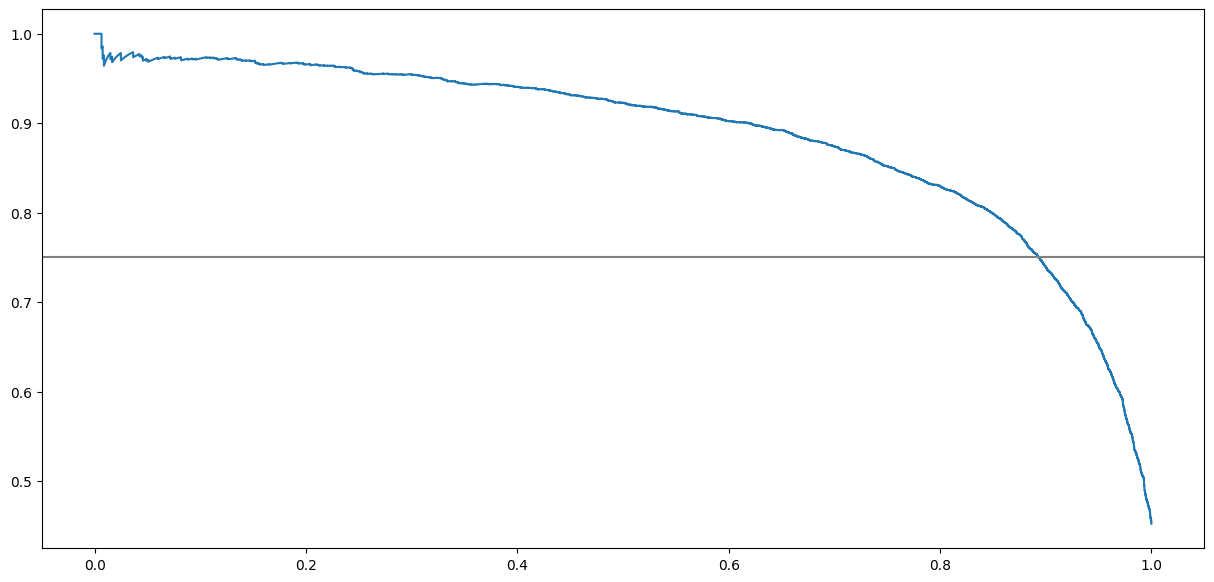

In [105]:
precision, recall, thrs = precision_recall_curve(valid[TARGET_NAME].values, valid['pred'])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

In [106]:
from scipy.integrate import simpson
from numpy import trapz

idx = precision >= 0.75

area = trapz(precision[idx][::-1], recall[idx][::-1], dx=1)
print("area =", area)

roc_auc = auc(recall[idx], precision[idx])
print("roc auc =", roc_auc)

area = 0.8181640656448964
roc auc = 0.8181640656448964


In [107]:
print(f'OOF score: {metric(train.target, train.pred, train.weights)}')
print(f'Valid score: {metric(valid.target, valid.pred, valid.weights)}')

OOF score: 0.7328324299048644
Valid score: 0.7212678685024942


In [108]:
def metric_cats(y_true, y_pred, sample_weight, dict_weigts):
    
    pr_aucs = []
    
    for name,w in dict_weigts.items():
        idx = sample_weight == w
        y_pred_cat = y_pred[idx]
        y_true_cat = y_true[idx]

        y, x, thr = precision_recall_curve(y_true_cat, y_pred_cat)
        gt_prec_level_idx = y >= 0.75
        threshold = np.append(thr,1)[y>=0.75][0]
        
        au = roc_auc_score(y_true_cat, y_pred_cat)

        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append({'cat3': name, 'PRAUC':pr_auc_prec_level,'weight': w , 'AUC': au,'threshold': threshold})
        except ValueError as err:
            pr_aucs.append({'cat3': name, 'PRAUC':0,'weight': w, 'AUC': au, 'threshold': threshold})

    
    return pd.DataFrame(pr_aucs).sort_values('PRAUC', ascending=False)

In [109]:
weights = valid[['cat3_grouped', 'weights']].drop_duplicates().set_index('cat3_grouped').to_dict()['weights']
stats = metric_cats(valid.target, valid.pred, valid.weights, weights)
stats.head(10)

,cat3,PRAUC,weight,AUC,threshold
41,Гаджет,1.000000,0.003097,1.000000,0.114962
1,Видеорегистратор,0.992124,0.004756,0.938095,0.046280
33,"Рюкзаки, чехлы, сумки",0.988953,0.004534,0.938776,0.068933
36,Микрофоны и аксессуары,0.980023,0.003926,0.907143,0.049876
3,Наушники и гарнитуры,0.974237,0.029418,0.865385,0.047475
31,Аксессуары для фото и видеотехники,0.968947,0.010285,0.982375,0.157989
24,Коврик для мыши,0.966628,0.010451,0.950680,0.151484
26,Кронштейн,0.962734,0.009456,0.877778,0.095752
16,Оптические приборы,0.962629,0.007355,0.895126,0.027496
4,Видеокамеры,0.956841,0.002820,0.887500,0.316554


In [110]:
stats

,cat3,PRAUC,weight,AUC,threshold
41,Гаджет,1.000000,0.003097,1.000000,0.114962
1,Видеорегистратор,0.992124,0.004756,0.938095,0.046280
33,"Рюкзаки, чехлы, сумки",0.988953,0.004534,0.938776,0.068933
36,Микрофоны и аксессуары,0.980023,0.003926,0.907143,0.049876
3,Наушники и гарнитуры,0.974237,0.029418,0.865385,0.047475
31,Аксессуары для фото и видеотехники,0.968947,0.010285,0.982375,0.157989
24,Коврик для мыши,0.966628,0.010451,0.950680,0.151484
26,Кронштейн,0.962734,0.009456,0.877778,0.095752
16,Оптические приборы,0.962629,0.007355,0.895126,0.027496
4,Видеокамеры,0.956841,0.002820,0.887500,0.316554


## 4. Model analysis

CPU times: total: 359 ms
Wall time: 2.5 s


,Feature,Importance
0,bert_sat,599060.358240
1,"Время зарядки аккумулятора, мин",73818.992476
2,lev_attr,50020.082129
3,abs_diff_id,31141.095519
4,lev_ratio_full_name,27917.559530
...,...,...
1013,Для геймеров,3.299870
1014,Максимальный формат оригинала,3.218990
1015,Тип насадки микроскопа,2.883940
1016,Количество поддерживаемых мониторов,2.427540


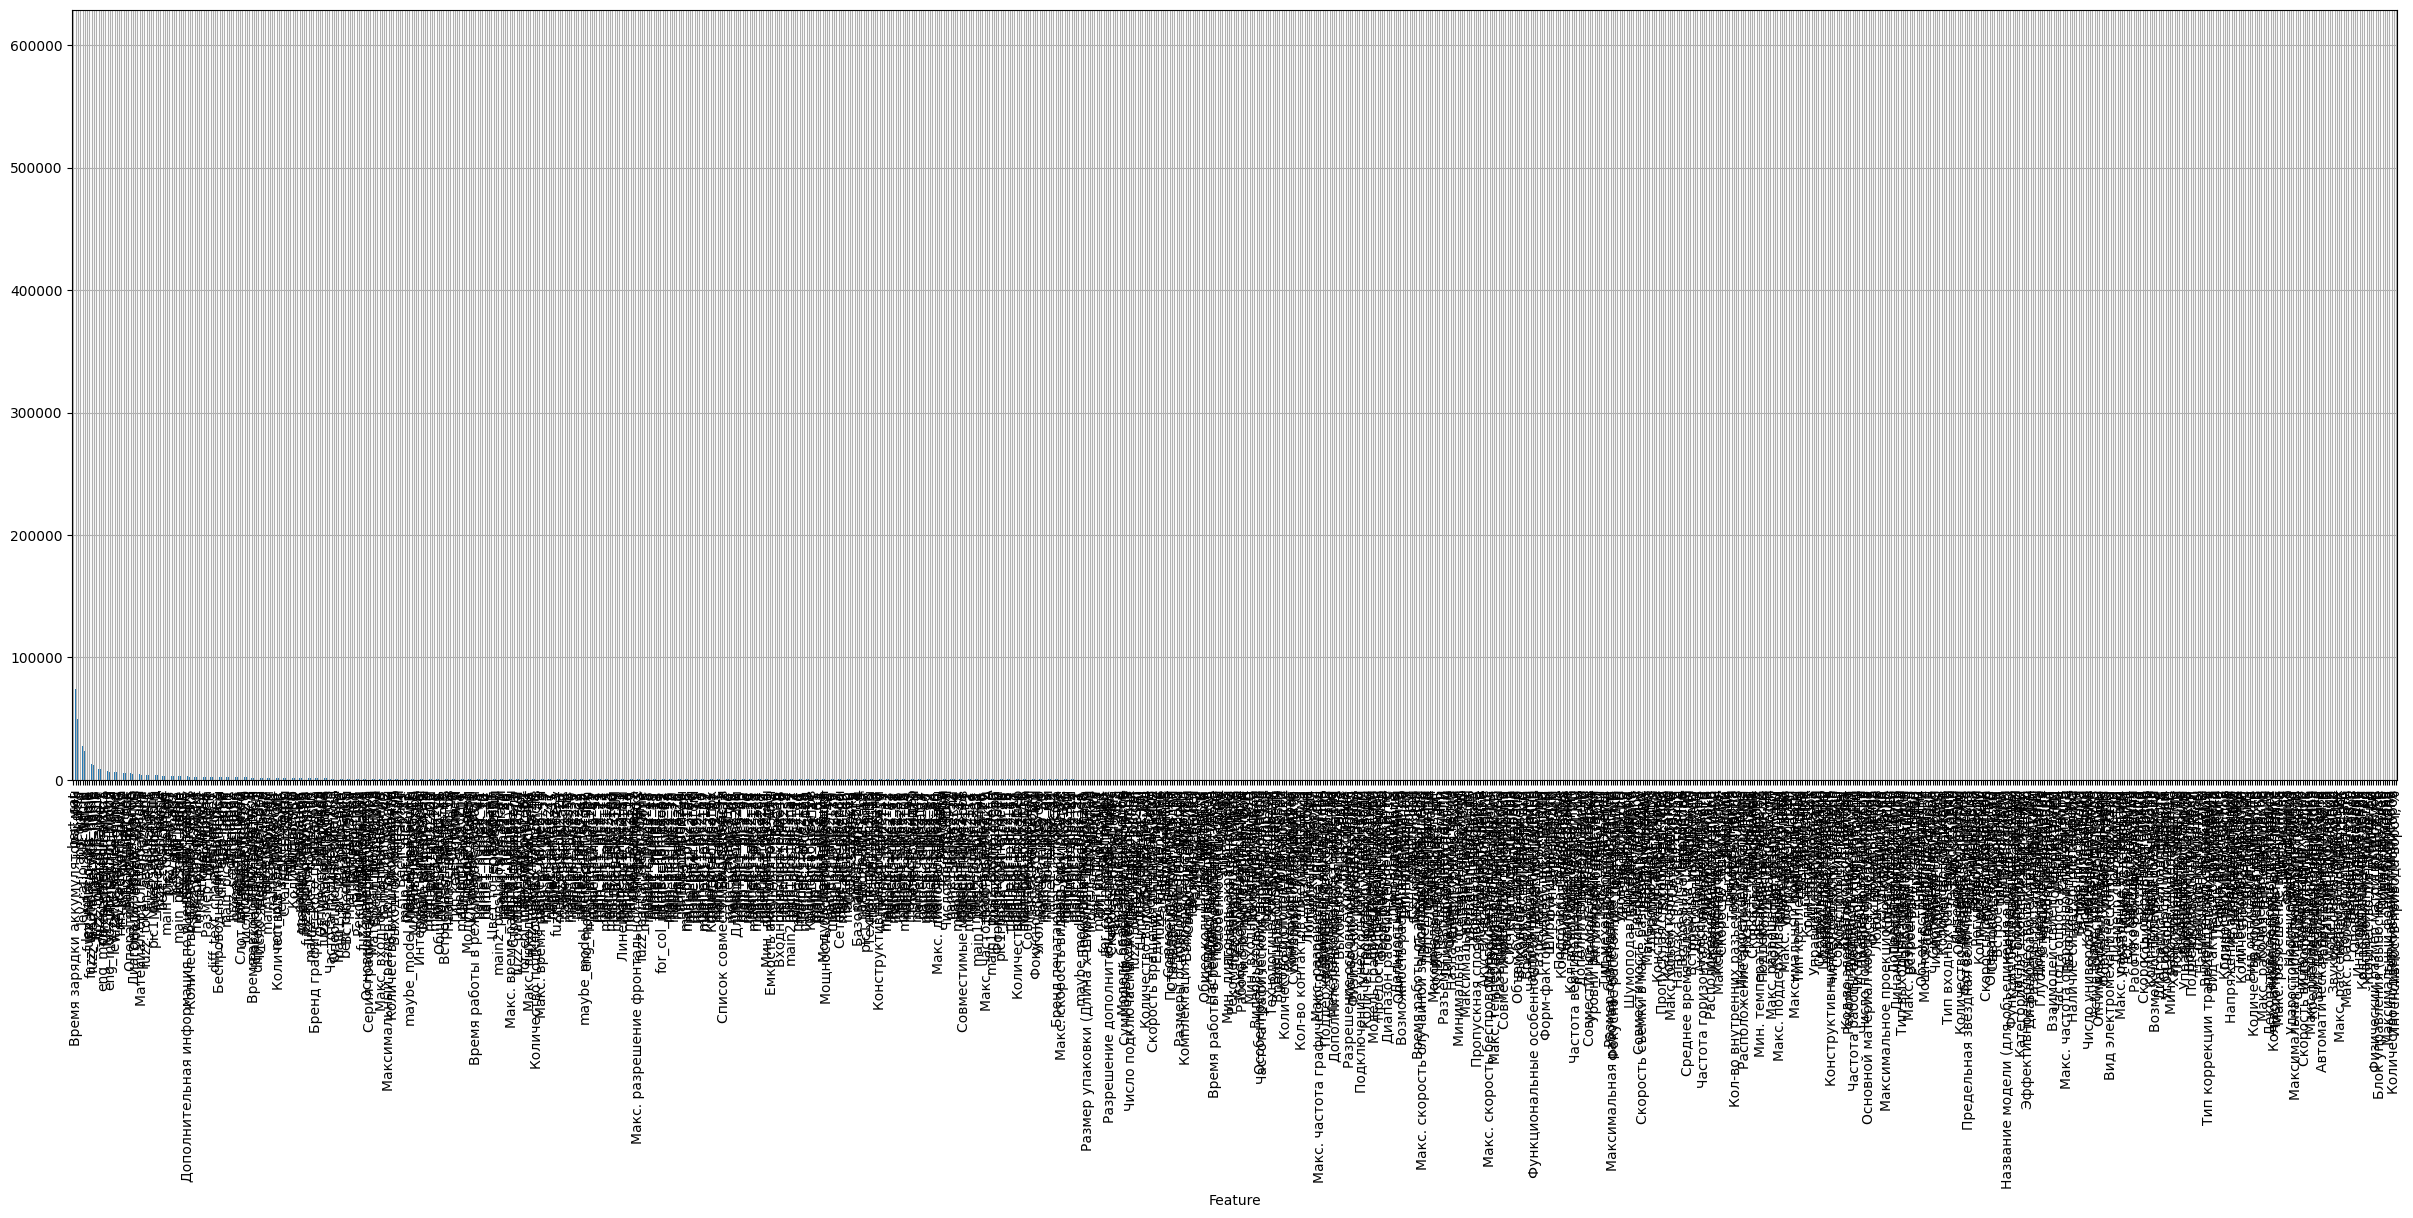

In [113]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)
fast_fi

In [111]:
test[TARGET_NAME] = automl.predict(test).data[:]

In [115]:
test.drop_duplicates(subset=['variantid1','variantid2']).to_csv('sub_last.csv', columns=['variantid1','variantid2', TARGET_NAME], index=False)

In [116]:
test.drop_duplicates(subset=['variantid1','variantid2'])

,variantid1,variantid2,cat3_grouped,weights,cnt_pics1,cnt_main_pics1,cnt_colors1,cat_31,cat_41,cnt_pics2,...,fuzz_eng_mod,fuzz_partial_eng_mod,fuzz_token_eng_mod,fuzz_WRatio_eng_mod,lev_eng_mod,lev_ratio_eng_mod,attr_emb_correlation,attr_emb_cosine,intersection_score,non_intersection_score
0,52076340,290590137,Батарейки и аккумуляторы,0.032957,1.0,1,1,Батарейки и аккумуляторы,Батарейка,1.0,...,86.0,82.0,86.0,89.0,8.0,0.862069,0.111711,0.107950,0.987484,1.000000
1,64525522,204128919,"Смартфоны, планшеты, мобильные телефоны",0.051150,4.0,1,3,"Смартфоны, планшеты, мобильные телефоны",Смартфон,1.0,...,94.0,94.0,94.0,94.0,1.0,0.937500,0.171204,0.169769,0.994213,1.000000
2,77243372,479860557,Кабели и переходники,0.059611,3.0,1,2,Кабели и переходники,Кабель,0.0,...,21.0,100.0,21.0,60.0,31.0,0.205128,0.156773,0.157125,0.907221,0.566928
3,86065820,540678372,Устройство ручного ввода,0.022838,14.0,1,1,Устройство ручного ввода,Мышь,4.0,...,68.0,73.0,64.0,70.0,9.0,0.680851,0.092685,0.093261,0.984371,0.531509
4,91566575,258840506,"Смартфоны, планшеты, мобильные телефоны",0.051150,1.0,1,2,"Смартфоны, планшеты, мобильные телефоны",Смартфон,1.0,...,76.0,75.0,57.0,86.0,5.0,0.761905,0.186990,0.187019,0.987514,0.523642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18110,666998614,667074522,Оперативная память,0.012221,3.0,1,1,Оперативная память,Модуль оперативной памяти,3.0,...,74.0,76.0,67.0,76.0,50.0,0.742616,0.013563,0.013562,0.973122,1.000000
18111,670036240,670048449,Зарядные устройства и док-станции,0.102245,0.0,1,1,Зарядные устройства и док-станции,Компьютерный блок питания,0.0,...,71.0,62.0,71.0,71.0,6.0,0.714286,0.055011,0.054820,0.982864,1.000000
18112,670284509,684323809,Смарт-часы,0.085435,0.0,1,2,Смарт-часы,Ремешок для смарт-часов,0.0,...,36.0,40.0,36.0,38.0,32.0,0.360656,0.120007,0.120009,0.973949,0.537917
18113,692172005,704805270,rest,0.029695,4.0,1,1,Проектор,Проектор,5.0,...,100.0,100.0,100.0,100.0,0.0,1.000000,0.102282,0.102203,1.000000,1.000000
